#  TempAtt exp4 (visual)

### Load & preprocess data

In [57]:
clear
clc
% close all

In [58]:
% define Paths: replace XXX by your own path
origDir = '/XXX/exp4/'; %!
addpath(genpath(origDir)); cd(origDir)

% define data
SUJETS = 1:31;
SUJETS( SUJETS==12 |SUJETS==16 | SUJETS==24 ) = []; % to remove the unfinished ones

In [59]:
% load data: 3 sessions per participant
IN = []; Dif = NaN(SUJETS(end),3);
for isuj = SUJETS
    subject = ['S' sprintf( '%02d', isuj ) ];  
        ifile = dir(['exp4a/TA18V_' subject '_1*.mat']);
        load([ifile(end).name])
        IN{isuj, 1} = X;
        Dif(isuj,1) = cfg.ndis;
    subject = ['S' sprintf( '%02d', isuj ) 'b'];
        ifile = dir(['exp4a/TA18V_' subject '_1*.mat']);
        load([ifile(end).name])
        IN{isuj, 2} = X;
        Dif(isuj,2) = cfg.ndis;
	if (~exist('beats1', 'var'))
        beats1 = cfg.fbeat(end:-1:1); % 8 values
    end
    subject = ['S' sprintf( '%02d', isuj ) 'c'];
        ifile = dir(['exp4b/TA18V_' subject '_1*.mat']);
        load([ifile(end).name])
        IN{isuj, 3} = X;
        Dif(isuj,3) = cfg.ndis;
	if (~exist('beats2', 'var'))
        beats2 = cfg.fbeat(end:-1:1); % 3 values
    end
    clear X subject ifile
end
Dif = mean(Dif,2);

In [60]:
% varnames
varname = {'Proportion Correct', 'Mean RT (ms)', 'Hit IE (sec)'};

In [61]:
% extract data
OUT{1} = NaN(SUJETS(end), length([beats1 beats2])); OUT{2} = OUT{1}; OUT{3} = OUT{2};
rout1 = [] ; rout2 = []; rout = [];
beats = [beats1 beats2(2:end)];

for isuj = SUJETS    
    % sessions 1&2
    for ibeat = 1:length(beats1)
        out = [];
        for isess = 1:2 %!
            y = IN{isuj,isess}.beat == beats1(ibeat);
            out{1}(isess,:) = IN{isuj,isess}.iscor(y);
            out{2}(isess,:) = IN{isuj,isess}.rt(y);
        end
        % group 2 sessions
            out{1} = reshape(out{1},[],1);
            out{2} = reshape(out{2},[],1);
        % nan rt >|< 2sd
            rtmin = mean(out{2}) -2*std(out{2});
            rtmax = mean(out{2}) +2*std(out{2});
            out{2}(out{2}>rtmax)  = NaN; out{2}(out{2}<rtmin) = NaN;
            out{1}(isnan(out{2})) = NaN;
        % avg trials
            OUT{1}(isuj,ibeat) = nanmean(out{1});
            OUT{2}(isuj,ibeat) = nanmean(out{2});
            OUT{3}(isuj,ibeat) = nanmean(out{2}) ./nanmean(out{1});    
    end    
    % sessions 3
    isess = 3; out = [];
    for ibeat = 1:length(beats2)
        y = IN{isuj,isess}.beat == beats2(ibeat);
        out{1} = IN{isuj,isess}.iscor(y);
        out{2} = IN{isuj,isess}.rt(y);
        % nan rt >|< 2sd
            rtmin = mean(out{2}) -2*std(out{2});
            rtmax = mean(out{2}) +2*std(out{2});
            out{2}(out{2}>rtmax)  = NaN; out{2}(out{2}<rtmin) = NaN;
            out{1}(isnan(out{2})) = NaN;
        % avg trials
            OUT{1}(isuj,length(beats1)+ibeat) = nanmean(out{1});
            OUT{2}(isuj,length(beats1)+ibeat) = nanmean(out{2});
            OUT{3}(isuj,length(beats1)+ibeat) = nanmean(out{2}) ./nanmean(out{1});
    end
end
clear x y rtmax out IN  isuj ibeat cfg

In [62]:
% remove unfinished/phantom (NaN) participants
OUT{1}(isnan(OUT{1}(:,1)),:) = [];
OUT{2}(isnan(OUT{2}(:,1)),:) = [];
OUT{3}(isnan(OUT{3}(:,1)),:) = [];
Dif(isnan(Dif)) = [];

In [63]:
% remove redundant fbeat across sessions 1&2 vs. 3 (to normalize number of trials across conditions)
OUTi{1} = OUT{1}(:,length(beats1)+1); 
    OUTi{2} = OUT{2}(:,length(beats1)+1);
    OUTi{3} = OUT{3}(:,length(beats1)+1);
OUT{1}(:,length(beats1)+1) = [];
    OUT{2}(:,length(beats1)+1) = [];
    OUT{3}(:,length(beats1)+1) = [];    
clear beats1 beats2

In [64]:
% define variable of interest
i0 = 1; % performance (or RT, or IE, see varname)
fit_order = 3; % fit order (n = 3)

In [65]:
% Fits per subject - define after rstudio analysis
xVec = (beats(end):0.01:beats(1));
Fit = [];
for j0 = 1:length(OUT{i0})
        x = OUT{i0}(j0,:);
        x = polyfit(log(beats), x, fit_order);
        Fit(j0) = exp((-x(2)-sqrt(x(2).^2-3.*x(1).*x(3)))./(3.*x(1))); % order 3
        % Fit(j0) = exp(-(x(2)./(2.*x(1)))); % order 2
end
Fit = real(Fit);
nsuj = length(Fit);

% save data for inter-experiment comparisons
save([origDir 'exp4_values.mat'], 'Fit', 'Dif');

In [66]:
% detect potential outliers (4std) in the Fit
olr = find((Fit>(mean(Fit)+4*std(Fit))));
% control range of Fit fq (should be between [0, 3.2])
[min(Fit), max(Fit)]


ans =

    0.3270    1.5945



### Statistics

In [67]:
% statistics
fprintf('\nParametric repeated-measure Anova on %s \n', varname{i0})
[~,F,~,~] = repanova(OUT{i0}, 10, {'Beat'});

% compute fit quality
x = mean(OUT{i0},1);
    y = polyfit(log(beats), x, fit_order);
    y = polyval(y, log(beats));
[r,p] = corr(x', y', 'type', 'Spearman');
fprintf('\n%1.0fnd order fit: r2=%1.2f, p=%1.3f \n', fit_order, r*r, p)


Parametric repeated-measure Anova on Proportion Correct 
Beat                 F(  9.00,243.00) =  53.564,	p = 0.0000

3nd order fit: r2=0.93, p=0.000 


### Figure

In [ ]:
% load data exp1
A = load('../exp1/exp1_values.mat');

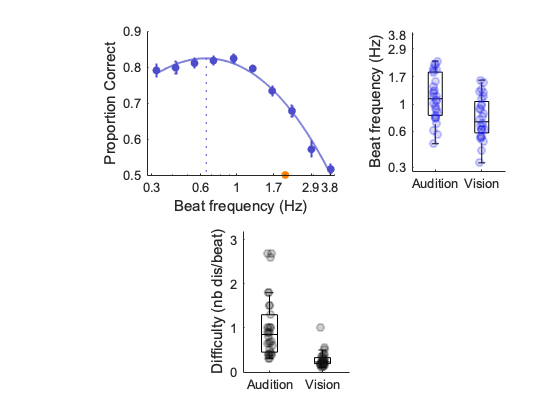

In [83]:
figure; set(gcf,'color','w'); colormap([.5 .5 .5; 1 1 1])

% 1. Difficulty
h = subplot(2,3, 5); hold on
group = [ones(size(A.Dif)); 2 * ones(size(Dif))];
    boxplot(zeros(10,1), 'colors','k','Widths',.01)
boxplot([A.Dif; Dif],group,'boxstyle','outline', 'colors','k','OutlierSize',4,'Symbol','','Widths',0.3)
scatter(ones(size(A.Dif)).*(1+(rand(size(A.Dif))-0.5)/10),A.Dif, ...
    'MarkerFaceColor',[.1 .1 .1],'MarkerEdgeColor','k',...
    'MarkerFaceAlpha',.2,'MarkerEdgeAlpha',.2)
scatter(ones(size(Dif)).*(2+(rand(size(Dif))-0.5)/10),Dif, ...
    'MarkerFaceColor',[.1 .1 .1],'MarkerEdgeColor','k',...
    'MarkerFaceAlpha',.2,'MarkerEdgeAlpha',.2)
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])    
ylabel( 'Difficulty (nb dis/beat)' )
    ylim( [.0, 3.2] ) %!
    yticks( [0 1 2 3] )
set(gca,'XTickLabel',{'Audition','Vision'})
    
    
% 3. boxplot individual preferred Fq
h = subplot(2,3, 3); hold on
group = [ones(size(A.Fit)); 2 * ones(size(Fit'))];
    boxplot(zeros(10,1), 'colors','k','Widths',.01)
boxplot([A.Fit; Fit'],group,'boxstyle','outline', 'colors','k','OutlierSize',4,'Symbol','','Widths',0.3)
scatter(ones(size(A.Fit)).*(1+(rand(size(A.Fit))-0.5)/10),A.Fit, ...
    'MarkerFaceColor',[.3 .3 .8],'MarkerEdgeColor','b',...
    'MarkerFaceAlpha',.2,'MarkerEdgeAlpha',.2)
scatter(ones(size(Fit')).*(2+(rand(size(Fit'))-0.5)/10),Fit', ...
    'MarkerFaceColor',[.3 .3 .8],'MarkerEdgeColor','b',...
    'MarkerFaceAlpha',.2,'MarkerEdgeAlpha',.2)
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])    
ylabel( 'Beat frequency (Hz)' )
    yticks( [.3 .6 1 1.7 2.9 3.8] )
    set(gca, 'YScale', 'log', 'YLim', [0.28, 4])
set(gca,'XTickLabel',{'Audition','Vision'})


% 2. plot performances
subplot(2,2, 1.3); hold on
x = bsxfun(@plus,bsxfun(@minus, OUT{i0}, mean(OUT{i0},2)), mean(OUT{i0}(:)));
errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.3 .3 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)

% + plot staircase
plot(2, .5, '.', 'color', [1 .5 .0], 'Linewidth', 2, 'MarkerSize', 15) %!
        
% + plot Fit
x = mean(OUT{i0},1);
    x = polyfit(log(beats), x, fit_order);
    freqpass = exp((-x(2)-sqrt(x(2).^2-3.*x(1).*x(3)))./(3.*x(1))); % order 3
    x = polyval(x, log(xVec));
    h = plot(xVec, x, 'color', [.3 .3 .8], 'Linewidth', 1.5);
    h.Color(4) = 0.7;

% + plot max fit
[~,b] = max(x);
maxpass = max(x);
h = line([xVec(b), xVec(b)], [.0, max(x)]);
    set(h, 'color', [.3 .3 .8], 'LineStyle', ':')
    
hold off
set(gca, 'FontSize', 10, 'FontName', 'Arial')
ylabel( varname{i0} )        
xlabel( 'Beat frequency (Hz)' )
set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
ylim( [.5, .9] ) %!
yticks( .5:.1:1 )       
    xticks( round(beats([end:-2:1 1]),1) )
    set(gca, 'XScale', 'log')
    xlim( [.28, 4] )

% Print Figure
cd(origDir)
%print('figure3b','-dpng','-r600')
f.PaperSize = [46.81 33.1];
f.PaperPosition(1:2) = [0 0];
print -dpdf figure3b.pdf

In [84]:
% Passive visual exp only
 fprintf('optimal beat frequency:  mean = %1.2f Hz, med = %1.2f Hz, std = %1.3f Hz \n', mean(Fit), quantile(Fit,[.5]), std(Fit))
 fprintf('difficulty level staircase:  mean = %1.2f , med = %1.2f , std = %1.3f  \n', mean(Dif), quantile(Dif,[.5]), std(Dif))
 fprintf('optimal beat frequency group-level:  %1.2f %%, %1.2f Hz \n', mean(maxpass), freqpass)
 

optimal beat frequency:  mean = 0.83 Hz, med = 0.72 Hz, std = 0.339 Hz 
difficulty level staircase:  mean = 0.28 , med = 0.23 , std = 0.179  
optimal beat frequency group-level:  0.82 %, 0.65 Hz 


### Statistics

In [87]:
% compare optimal beat in audition (exp1) vs vision (exp4)
[h,p,ci,stats] = ttest2(A.Fit,Fit, 'VarType', 'unequal'); % unpaired welsh t test
    fprintf('optimal beat frequency: p= %6.4f,  t= %6.4f,  df= %6.2f\n', p, stats.tstat, stats.df)
    fprintf('   df without Welch-Satterthwaite correction : %1.0f\n',length(Fit)+length(A.Fit)-2);
clear x y  h p ci stats

optimal beat frequency: p= 0.0028,  t= 3.1848,  df=  39.62
     df without Welch-Satterthwaite correction : 56


In [88]:
% compare difficulty level in audition (exp1) vs vision (exp4)
[h,p,ci,stats] = ttest2(Dif,A.Dif, 'VarType', 'unequal'); % unpaired welsh t test
    fprintf('Difficulty level (staircase): p= %6.4f,  t= %6.4f,  df= %6.2f\n', p, stats.tstat, stats.df)
    fprintf('   df without Welch-Satterthwaite correction : %1.0f\n',length(Dif)+length(A.Dif)-2);
clear x y  h p ci stats

Difficulty level : p= 0.0000,  t= -5.5188,  df=  33.02
   df without Welch-Satterthwaite correction : 56
